In [50]:
import json
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import math
from itertools import permutations

In [39]:
# load data
with open("us_state_capitals_with_coordinates.json", "r") as f:
    data = json.load(f)
df = pd.DataFrame(data)

start = "Iowa"
end = "Washington"

### Functions

In [16]:
def haversine(lat1, lon1, lat2, lon2):
    '''
    calculate the great-circle distance between two points on the Earth
    specified in decimal degrees using the Haversine formula.
    '''
    R = 6371
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    delta_phi = phi2 - phi1
    delta_lambda = math.radians(lon2 - lon1)
    a = math.sin(delta_phi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(delta_lambda/2)**2
    return R * (2 * math.atan2(math.sqrt(a), math.sqrt(1 - a)))

In [17]:
def geographic_centroid_df(df: pd.DataFrame, lat_col: str = "latitude", lon_col: str = "longitude") -> list:
    """
    Compute the geographic centroid (spherical method) from a DataFrame.

    Parameters:
        df: pandas DataFrame containing latitude and longitude columns
        lat_col: name of the latitude column (default: "lat")
        lon_col: name of the longitude column (default: "lon")

    Returns:
        A list [latitude, longitude] in degrees representing the centroid
    """
    if df.empty:
        raise ValueError("The DataFrame is empty. Cannot compute centroid.")

    x = y = z = 0.0

    # Convert each (lat, lon) to Cartesian coordinates and accumulate
    for _, row in df.iterrows():
        lat = math.radians(row[lat_col])
        lon = math.radians(row[lon_col])
        x += math.cos(lat) * math.cos(lon)
        y += math.cos(lat) * math.sin(lon)
        z += math.sin(lat)

    # Average the x, y, z components
    total = len(df)
    x /= total
    y /= total
    z /= total

    # Convert the average Cartesian coordinates back to latitude and longitude
    lon_center = math.atan2(y, x)
    hyp = math.sqrt(x * x + y * y)
    lat_center = math.atan2(z, hyp)

    return [math.degrees(lat_center), math.degrees(lon_center)]

#### Nearest neighbor & 2-opt

In [ ]:
def route_distance(route, coords):
    return sum(haversine(*coords[route[i]], *coords[route[i+1]]) for i in range(len(route)-1))

In [19]:
def nearest_neighbor_path(df, start, end, lat_col, lon_col):
    n = len(df)
    unvisited = set(range(n))
    unvisited.remove(start)
    if end in unvisited:
        unvisited.remove(end)

    route = [start]
    current = start
    while unvisited:
        next_city = min(unvisited, key=lambda i: haversine(
            df.iloc[current][lat_col], df.iloc[current][lon_col],
            df.iloc[i][lat_col], df.iloc[i][lon_col]
        ))
        route.append(next_city)
        unvisited.remove(next_city)
        current = next_city

    route.append(end)
    return route

In [ ]:
def two_opt_path(route, coords):
    best = route[:]
    improved = True
    while improved:
        improved = False
        for i in range(1, len(route) - 3):
            for j in range(i + 1, len(route) - 1):
                if j - i == 1:
                    continue
                new_route = best[:i] + best[i:j][::-1] + best[j:]
                if route_distance(new_route, coords) < route_distance(best, coords):
                    best = new_route
                    improved = True
    return best

#### Brute force

In [ ]:
def path_distance(route, df):
    """Compute the total distance of a given route"""
    total = 0
    for i in range(len(route) - 1):
        lat1, lon1 = df.loc[route[i], ['latitude', 'longitude']]
        lat2, lon2 = df.loc[route[i+1], ['latitude', 'longitude']]
        total += haversine(lat1, lon1, lat2, lon2)
    return total

In [23]:
def solve_tsp_brute_force(df, start_index, end_index, lat_col="latitude", lon_col="longitude"):
    """
    Brute-force solution for open-path TSP with fixed start and end.

    Parameters:
        df: DataFrame with coordinates
        start_index: starting point index
        end_index: ending point index
        lat_col, lon_col: names of lat/lon columns

    Returns:
        (shortest_path_indices, total_distance)
    """
    n = len(df)
    indices = list(range(n))
    
    # exclude start and end from permutations
    middle_nodes = [i for i in indices if i not in (start_index, end_index)]
    
    best_route = None
    min_dist = float('inf')

    for perm in permutations(middle_nodes):
        route = [start_index] + list(perm) + [end_index]
        dist = path_distance(route, df, lat_col, lon_col)
        if dist < min_dist:
            best_route = route
            min_dist = dist

    return best_route, min_dist

### Step 1: Cluster

In [40]:
# cluster
k = 10
kmeans = KMeans(n_clusters=k, random_state=42).fit(df[["latitude", "longitude"]])
df["cluster"] = kmeans.labels_

In [41]:
for i in range(k):
    group = df[df["cluster"] == i]
    print(f"\nCluster {i + 1} ({len(group)} cities):")
    for _, row in group.iterrows():
        print(f" - {row['capital']}, {row['state']}")


Cluster 1 (7 cities):
 - Hartford, Connecticut
 - Augusta, Maine
 - Boston, Massachusetts
 - Concord, New Hampshire
 - Albany, New York
 - Providence, Rhode Island
 - Montpelier, Vermont

Cluster 2 (3 cities):
 - Boise, Idaho
 - Helena, Montana
 - Salt Lake City, Utah

Cluster 3 (6 cities):
 - Springfield, Illinois
 - Indianapolis, Indiana
 - Frankfort, Kentucky
 - Lansing, Michigan
 - Columbus, Ohio
 - Madison, Wisconsin

Cluster 4 (4 cities):
 - Sacramento, California
 - Carson City, Nevada
 - Salem, Oregon
 - Olympia, Washington

Cluster 5 (1 cities):
 - Honolulu, Hawaii

Cluster 6 (8 cities):
 - Des Moines, Iowa
 - Topeka, Kansas
 - Saint Paul, Minnesota
 - Jefferson City, Missouri
 - Lincoln, Nebraska
 - Bismarck, North Dakota
 - Oklahoma City, Oklahoma
 - Pierre, South Dakota

Cluster 7 (7 cities):
 - Montgomery, Alabama
 - Little Rock, Arkansas
 - Tallahassee, Florida
 - Atlanta, Georgia
 - Baton Rouge, Louisiana
 - Jackson, Mississippi
 - Nashville, Tennessee

Cluster 8 (5 cit

In [52]:
df

,state,capital,address,valid address?,latitude,longitude,cluster
0,Alabama,Montgomery,"{'street': '600 Dexter Ave', 'city': 'Montgome...",Address found,32.377420,-86.309168,6
1,Alaska,Juneau,"{'street': '120 4th St', 'city': 'Juneau', 'st...",Address found,58.301950,-134.419734,8
2,Arizona,Phoenix,"{'street': '1700 W Washington St', 'city': 'Ph...",Address found,33.448437,-112.074141,7
3,Arkansas,Little Rock,"{'street': '500 Woodlane St', 'city': 'Little ...",Address found,34.746507,-92.289627,6
4,California,Sacramento,"{'street': '1315 10th St', 'city': 'Sacramento...",Address found,38.581061,-121.493895,3
5,Colorado,Denver,"{'street': '200 E Colfax Ave', 'city': 'Denver...",Address found,39.739236,-104.984862,7
6,Connecticut,Hartford,"{'street': '210 Capitol Ave', 'city': 'Hartfor...",Address found,41.764582,-72.690855,0
7,Delaware,Dover,"{'street': '411 Legislative Ave', 'city': 'Dov...",Address found,39.158168,-75.524368,9
8,Florida,Tallahassee,"{'street': '400 S Monroe St', 'city': 'Tallaha...",Address found,30.438083,-84.280933,6
9,Georgia,Atlanta,"{'street': '206 Washington St SW', 'city': 'At...",Address found,33.754466,-84.389815,6


C:\Users\木木小呆猪\AppData\Local\Temp\ipykernel_25432\3654726013.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', k)


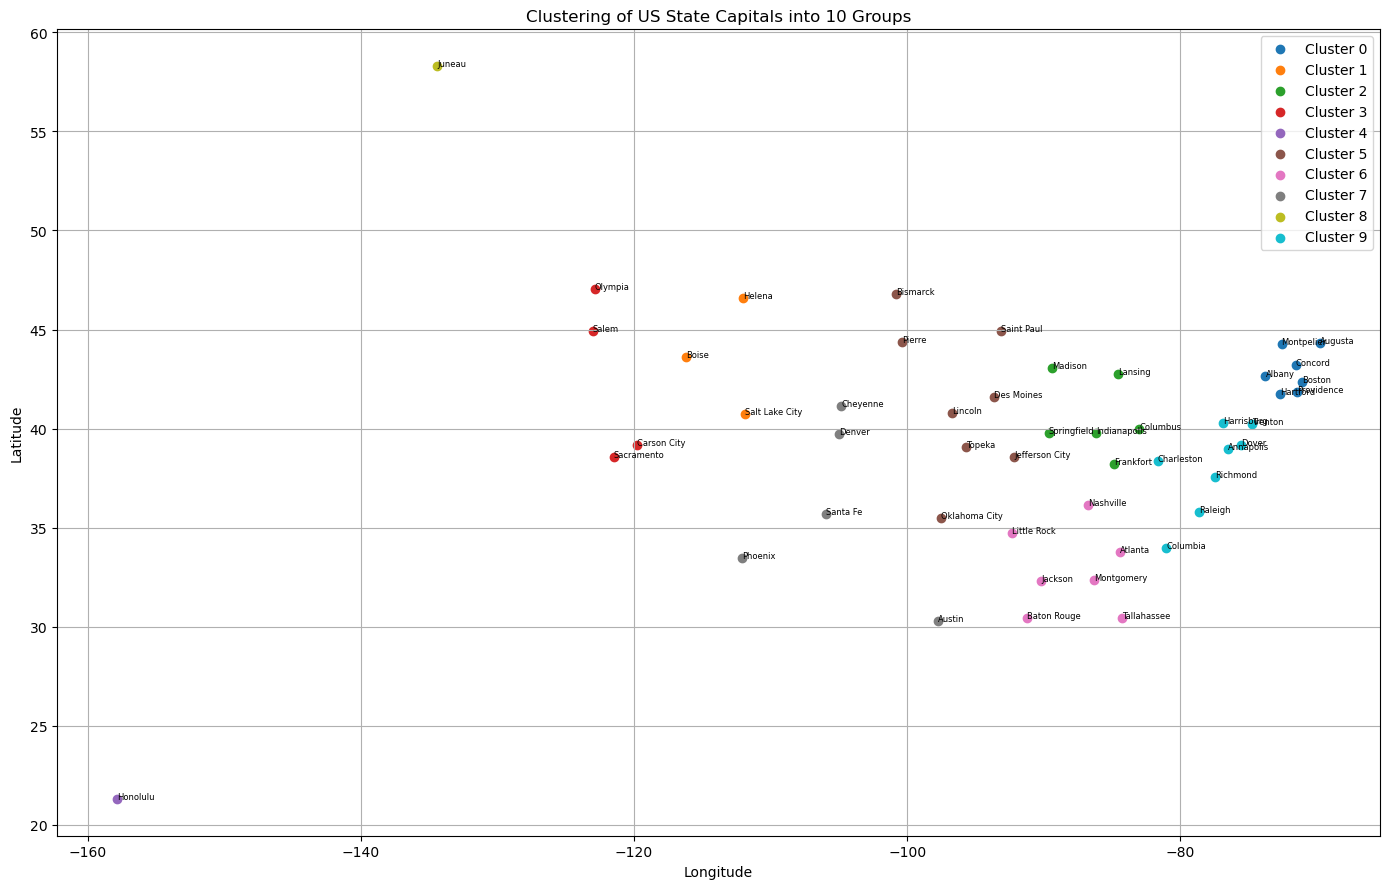

In [42]:
colors = plt.cm.get_cmap('tab10', k)
plt.figure(figsize=(14, 9))

for i in range(k):
    group = df[df["cluster"] == i]
    plt.scatter(group["longitude"], group["latitude"], color=colors(i), label=f"Cluster {i}")
    for _, row in group.iterrows():
        plt.text(row["longitude"], row["latitude"], row["capital"], fontsize=6)

plt.title(f"Clustering of US State Capitals into {k} Groups")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("us_capitals_clusters.png", dpi=300)  
plt.show()


### Step 2: locate center of each cluster

In [43]:
df_cluster = df.groupby("cluster").apply(geographic_centroid_df).reset_index(name="centroid")
df_cluster['latitude'] = df_cluster['centroid'].apply(lambda x: x[0])
df_cluster['longitude'] = df_cluster['centroid'].apply(lambda x: x[1])

C:\Users\木木小呆猪\AppData\Local\Temp\ipykernel_25432\385270901.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cluster = df.groupby("cluster").apply(geographic_centroid_df).reset_index(name="centroid")


In [44]:
df_cluster

,cluster,centroid,latitude,longitude
0,0,"[42.91757413692964, -71.83533444544146]",42.917574,-71.835334
1,1,"[43.673778349643, -113.37410143500972]",43.673778,-113.374101
2,2,"[40.61601777311713, -86.25165382489915]",40.616018,-86.251654
3,3,"[42.440242031706774, -121.73338288823389]",42.440242,-121.733383
4,4,"[21.304547, -157.855676]",21.304547,-157.855676
5,5,"[41.49123956757826, -96.18005274838362]",41.491240,-96.180053
6,6,"[32.92639975286173, -87.91324726916997]",32.926400,-87.913247
7,7,"[36.1482406702992, -105.06284391065876]",36.148241,-105.062844
8,8,"[58.30194959999999, -134.419734]",58.301950,-134.419734
9,9,"[38.059840237655635, -77.84484678480334]",38.059840,-77.844847


C:\Users\木木小呆猪\AppData\Local\Temp\ipykernel_25432\90646862.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', k)


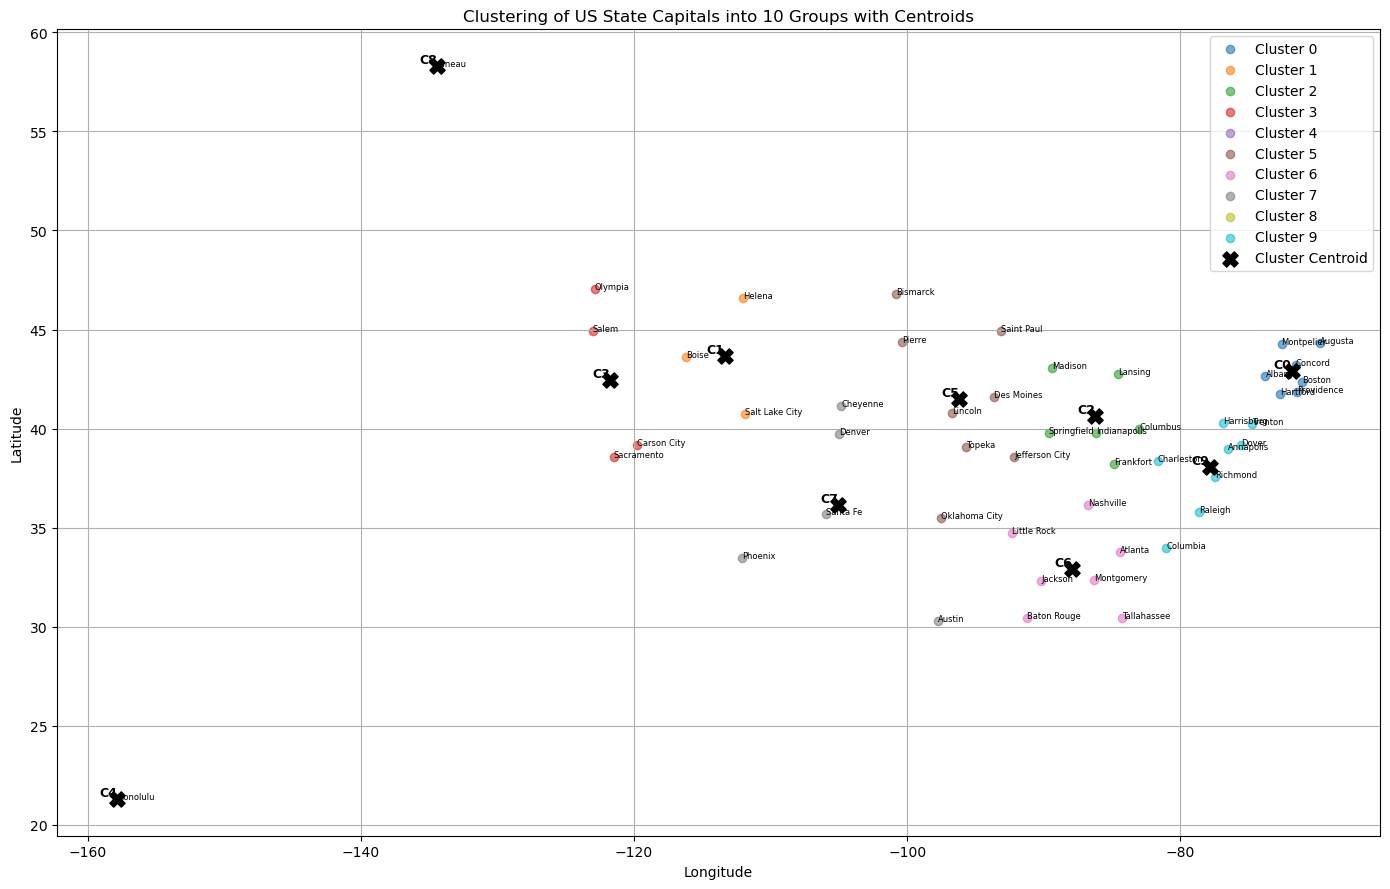

In [45]:
import matplotlib.pyplot as plt

colors = plt.cm.get_cmap('tab10', k)
plt.figure(figsize=(14, 9))

for i in range(k):
    group = df[df["cluster"] == i]
    plt.scatter(group["longitude"], group["latitude"], color=colors(i), label=f"Cluster {i}", alpha=0.6)
    for _, row in group.iterrows():
        plt.text(row["longitude"], row["latitude"], row["capital"], fontsize=6)

plt.scatter(df_cluster["longitude"], df_cluster["latitude"], 
            color='black', marker='X', s=120, label="Cluster Centroid")

for _, row in df_cluster.iterrows():
    plt.text(row["longitude"], row["latitude"], f"C{int(row['cluster'])}", 
             fontsize=9, color='black', fontweight='bold', ha='right', va='bottom')

plt.title(f"Clustering of US State Capitals into {k} Groups with Centroids")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Step 3: order for cluster

In [ ]:
# Here we find the clusters for the start and end states
start_cluster = df.query("capital == @start or state == @start")['cluster'].values[0]
end_cluster = df.query("capital == @end or state == @end")['cluster'].values[0]

In [53]:
# Use the centroid in df_cluster to represent each cluster
# Compute the shortest path between cluster centroids using brute force
cluster_order, total_dist = solve_tsp_brute_force(
    df=df_cluster,
    start_index=5,
    end_index=3,
    lat_col="latitude",
    lon_col="longitude"
)

print("Shortest path indices:", cluster_order)
print("Visit order:", [f"Cluster {i}" for i in cluster_order])
print(f"Total path distance: {total_dist:.2f} km")

Shortest path indices: [5, 2, 0, 9, 6, 7, 1, 8, 4, 3]
Visit order: ['Cluster 5', 'Cluster 2', 'Cluster 0', 'Cluster 9', 'Cluster 6', 'Cluster 7', 'Cluster 1', 'Cluster 8', 'Cluster 4', 'Cluster 3']
Total path distance: 17373.05 km


### Step 4: connection from 1 cluster to another

In [61]:
# Based on the cluster order obtained from the previous step
# The start city of the first cluster is Iowa, and the end city of the last cluster is Washington
# In this step, we want to find the optimal start and end city within each cluster
# Basic idea:
# For each pair of adjacent clusters, find the pair of cities (one from each cluster) that are closest to each other.
# Use the city in the earlier cluster as its "end", and the city in the next cluster as its "start".

# Initialize "start" and "end" columns
df_cluster["start"] = np.nan
df_cluster["end"] = np.nan

# Manually set the known start and end cities
df_cluster.loc[5, "start"] = start_cluster = df.query("capital == @start or state == @start")['capital'].values[0]
df_cluster.loc[3, "end"] = end_cluster = df.query("capital == @end or state == @end")['capital'].values[0]

# Loop through cluster_order to find best connecting cities between adjacent clusters
for i in range(len(cluster_order)):
    curr_cluster = cluster_order[i]
    curr_cities = df[df["cluster"] == curr_cluster]
    
    # Previous cluster → current cluster: determine current cluster's "start" city
    if i > 0:
        prev_cluster = cluster_order[i - 1]
        prev_cities = df[df["cluster"] == prev_cluster]

        min_dist = float("inf")
        best_start = None

        for _, city1 in curr_cities.iterrows():
            for _, city2 in prev_cities.iterrows():
                d = haversine(city1["latitude"], city1["longitude"], city2["latitude"], city2["longitude"])
                if d < min_dist:
                    min_dist = d
                    best_start = city1["capital"]
        
        df_cluster.loc[curr_cluster, "start"] = best_start

    # Current cluster → next cluster: determine current cluster's "end" city
    if i < len(cluster_order) - 1:
        next_cluster = cluster_order[i + 1]
        next_cities = df[df["cluster"] == next_cluster]

        min_dist = float("inf")
        best_end = None

        for _, city1 in curr_cities.iterrows():
            for _, city2 in next_cities.iterrows():
                d = haversine(city1["latitude"], city1["longitude"], city2["latitude"], city2["longitude"])
                if d < min_dist:
                    min_dist = d
                    best_end = city1["capital"]
        
        df_cluster.loc[curr_cluster, "end"] = best_end


C:\Users\木木小呆猪\AppData\Local\Temp\ipykernel_25432\1123746998.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Des Moines' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_cluster.loc[5, "start"] = start_cluster = df.query("capital == @start or state == @start")['capital'].values[0]
C:\Users\木木小呆猪\AppData\Local\Temp\ipykernel_25432\1123746998.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Olympia' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_cluster.loc[3, "end"] = end_cluster = df.query("capital == @end or state == @end")['capital'].values[0]


In [62]:
df_cluster

,cluster,centroid,latitude,longitude,start,end
0,0,"[42.91757413692964, -71.83533444544146]",42.917574,-71.835334,Albany,Hartford
1,1,"[43.673778349643, -113.37410143500972]",43.673778,-113.374101,Salt Lake City,Helena
2,2,"[40.61601777311713, -86.25165382489915]",40.616018,-86.251654,Springfield,Columbus
3,3,"[42.440242031706774, -121.73338288823389]",42.440242,-121.733383,Sacramento,Olympia
4,4,"[21.304547, -157.855676]",21.304547,-157.855676,Honolulu,Honolulu
5,5,"[41.49123956757826, -96.18005274838362]",41.491240,-96.180053,Des Moines,Jefferson City
6,6,"[32.92639975286173, -87.91324726916997]",32.926400,-87.913247,Atlanta,Baton Rouge
7,7,"[36.1482406702992, -105.06284391065876]",36.148241,-105.062844,Austin,Cheyenne
8,8,"[58.30194959999999, -134.419734]",58.301950,-134.419734,Juneau,Juneau
9,9,"[38.059840237655635, -77.84484678480334]",38.059840,-77.844847,Trenton,Columbia


### Step 5: order inside each cluster

In [ ]:
# Dictionary to store results
cluster_paths = {}

# Loop over each cluster
for idx, row in df_cluster.iterrows():
    c = row["cluster"]
    start_city = row["start"]
    end_city = row["end"]

    # Skip if start or end is missing
    if pd.isna(start_city) or pd.isna(end_city):
        continue

    # Extract all cities in the current cluster
    cities = df[df["cluster"] == c].reset_index()

    # Get the index of the start and end cities
    start_idx = cities[cities["capital"] == start_city].index[0]
    end_idx = cities[cities["capital"] == end_city].index[0]

    # Indices of the middle cities
    middle_indices = [i for i in range(len(cities)) if i not in (start_idx, end_idx)]

    # Try all permutations of the middle cities
    min_path = []
    min_dist = float("inf")

    for perm in permutations(middle_indices):
        route = [start_idx] + list(perm) + [end_idx]
        dist = path_distance(route, cities)
        if dist < min_dist:
            min_dist = dist
            min_path = route

    # Save the result for this cluster
    cluster_paths[c] = {
        "route_index": min_path,
        "route_city": [cities.loc[i, "capital"] for i in min_path],
        "distance_km": round(min_dist, 2)
    }

In [65]:
for c, result in cluster_paths.items():
    print(f"\nCluster {c} shortest path:")
    print(" → ".join(result["route_city"]))
    print(f"Total distance: {result['distance_km']} km")


Cluster 0 shortest path:
Albany → Montpelier → Augusta → Concord → Boston → Providence → Hartford
Total distance: 888.04 km

Cluster 1 shortest path:
Salt Lake City → Boise → Helena
Total distance: 941.59 km

Cluster 2 shortest path:
Springfield → Madison → Lansing → Indianapolis → Frankfort → Columbus
Total distance: 1576.52 km

Cluster 3 shortest path:
Sacramento → Carson City → Salem → Olympia
Total distance: 1093.55 km

Cluster 4 shortest path:
Honolulu → Honolulu
Total distance: 0.0 km

Cluster 5 shortest path:
Des Moines → Saint Paul → Bismarck → Pierre → Lincoln → Topeka → Oklahoma City → Jefferson City
Total distance: 3005.86 km

Cluster 6 shortest path:
Atlanta → Tallahassee → Montgomery → Nashville → Little Rock → Jackson → Baton Rouge
Total distance: 2166.27 km

Cluster 7 shortest path:
Austin → Phoenix → Santa Fe → Denver → Cheyenne
Total distance: 2626.42 km

Cluster 8 shortest path:
Juneau → Juneau
Total distance: 0.0 km

Cluster 9 shortest path:
Trenton → Harrisburg → D

### Step 6: optimization

In [ ]:
# Combine all cluster paths into a single route
full_city_path = []

for c in cluster_order:
    if c in cluster_paths:
        full_city_path.extend(cluster_paths[c]["route_city"])

In [77]:
cluster_order

[5, 2, 0, 9, 6, 7, 1, 8, 4, 3]

In [ ]:
# Remove consecutive duplicates in the full path
cleaned_path = [full_city_path[0]]  

for city in full_city_path[1:]:
    if city != cleaned_path[-1]:
        cleaned_path.append(city)

full_city_path = cleaned_path

In [73]:
# derive coordinates for the full path
city_coords = []
for city in full_city_path:
    row = df[df["capital"] == city].iloc[0]
    city_coords.append((row["latitude"], row["longitude"]))

In [75]:
# initialize the route with indices of the cities in full_city_path
initial_route = list(range(len(city_coords)))

# 2-opt optimization
optimized_route = two_opt_path(initial_route, city_coords)

# Convert optimized indices back to city names
optimized_city_path = [full_city_path[i] for i in optimized_route]
optimized_distance = route_distance(optimized_route, city_coords)

print("Optimized path:")
print(" → ".join(optimized_city_path))
print(f"Total distance after 2-opt: {optimized_distance:.2f} km")


Optimized path:
Des Moines → Saint Paul → Bismarck → Pierre → Lincoln → Topeka → Oklahoma City → Jefferson City → Springfield → Madison → Lansing → Indianapolis → Frankfort → Columbus → Charleston → Harrisburg → Albany → Montpelier → Augusta → Concord → Boston → Providence → Hartford → Trenton → Dover → Annapolis → Richmond → Raleigh → Columbia → Atlanta → Tallahassee → Montgomery → Nashville → Little Rock → Jackson → Baton Rouge → Austin → Phoenix → Santa Fe → Denver → Cheyenne → Salt Lake City → Boise → Helena → Juneau → Honolulu → Sacramento → Carson City → Salem → Olympia
Total distance after 2-opt: 26765.55 km


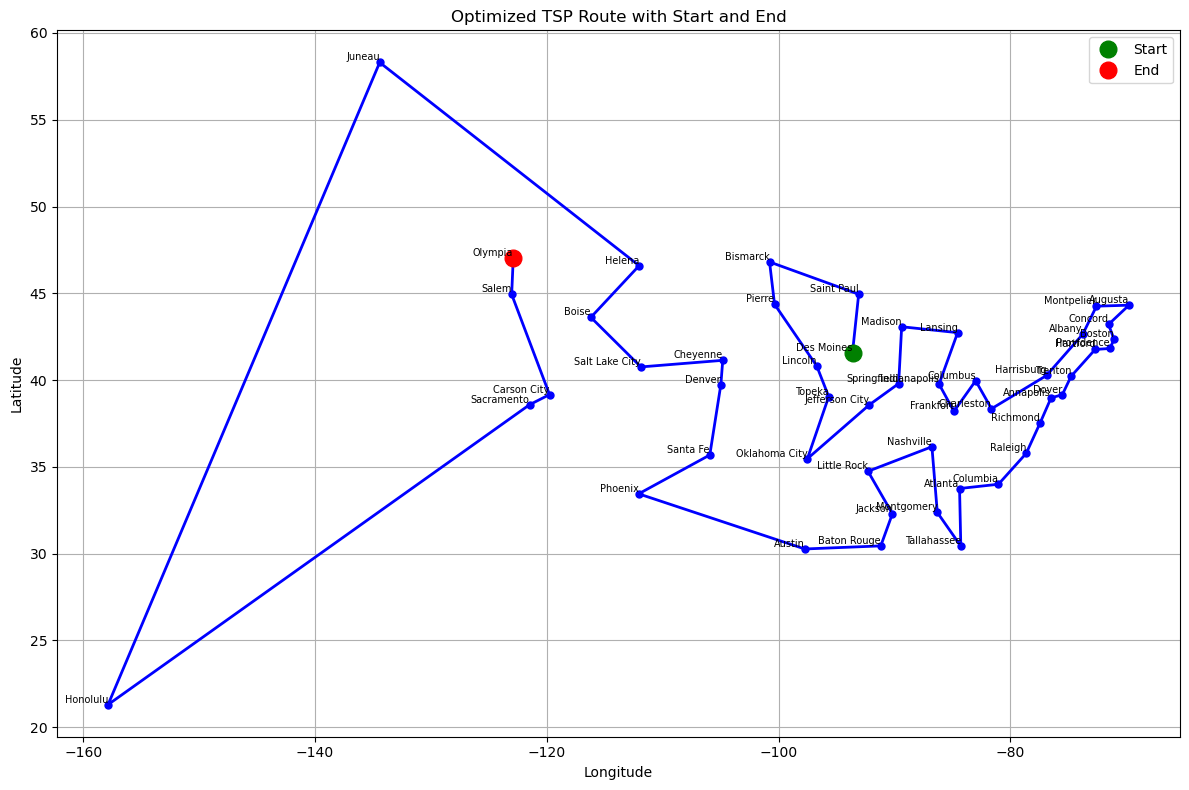

In [ ]:
# Get the coordinates of each city in the optimized path
optimized_coords = []
for city in optimized_city_path:
    row = df[df["capital"] == city].iloc[0]
    optimized_coords.append((row["latitude"], row["longitude"]))

# Split into latitude and longitude lists
lats = [coord[0] for coord in optimized_coords]
lons = [coord[1] for coord in optimized_coords]

# Plot the path
plt.figure(figsize=(12, 8))
plt.plot(lons, lats, '-o', color='blue', linewidth=2, markersize=5)

# Annotate city names
for i, city in enumerate(optimized_city_path):
    plt.text(lons[i], lats[i], city, fontsize=7, ha='right', va='bottom')

# Highlight the start point (green) and end point (red)
plt.plot(lons[0], lats[0], 'go', markersize=12, label="Start")
plt.plot(lons[-1], lats[-1], 'ro', markersize=12, label="End")

# Add legend and labels
plt.title("Optimized TSP Route with Start and End")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()